In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.statistics import check_seasonality
from darts.models.forecasting.baselines import NaiveSeasonal
from darts.metrics import mae
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr
from sklearn.preprocessing import RobustScaler

from quant_invest_lab.data_provider import download_crypto_historical_data


In [2]:
symbol = "BTC-USDT"

df_BTC = download_crypto_historical_data(symbol, "1day").loc["2020-11-20":]
df_BTC['Log_returns'] = np.log(df_BTC['Close']).pct_change()
df_BTC.index = df_BTC.index.map(lambda x: datetime.datetime(x.year, x.month, x.day))
df_BTC.dropna(inplace=True)

print(df_BTC.shape)

df_BTC.head()


(909, 9)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_returns
Date,,,,,,,,,
2020-11-21,1.605917e+09,18659.4,18702.2,18964.9,18322.3,2063.264695,3.856744e+07,0.002294,0.000233
2020-11-22,1.606003e+09,18702.2,18416.9,18749.1,17622.2,2373.600444,4.350419e+07,-0.015255,-0.001563
2020-11-23,1.606090e+09,18415.1,18370.6,18762.0,18009.0,2338.730168,4.307173e+07,-0.002514,-0.000256
2020-11-24,1.606176e+09,18370.3,19153.2,19412.5,17999.9,3392.945212,6.402286e+07,0.042601,0.004249
2020-11-25,1.606262e+09,19160.0,18723.3,19480.0,18479.7,2559.635826,4.867373e+07,-0.022445,-0.002302


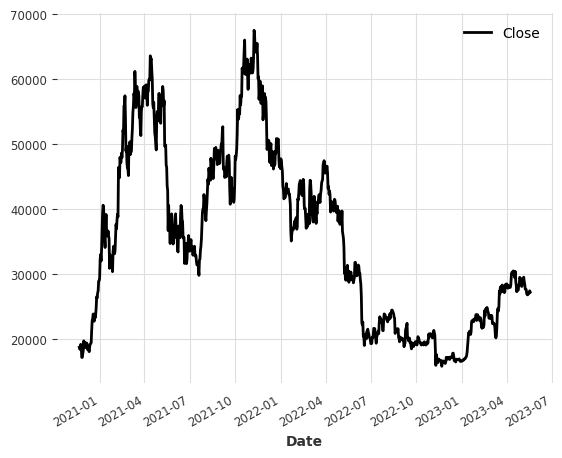

In [3]:
series = TimeSeries.from_dataframe(df_BTC[["Close"]], fill_missing_dates=True, freq="D")

series.plot()

In [4]:
is_daily_seasonal, daily_period = check_seasonality(
    series, m=None, max_lag=400, alpha=0.05
)

print(f"Daily seasonality: {is_daily_seasonal} - period = {daily_period}")

Daily seasonality: True - period = 114


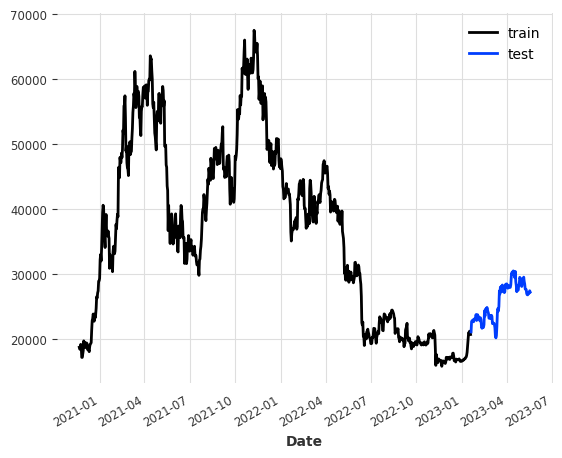

In [5]:
train, test = series[:-120], series[-120:]

train.plot(label="train")
test.plot(label="test")

7531.873684210526


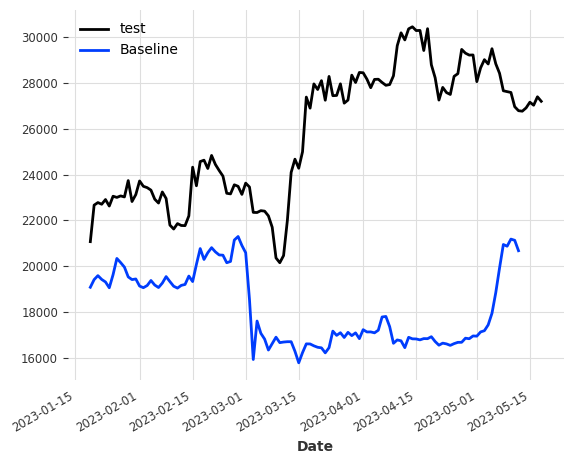

In [6]:
naive_seasonal = NaiveSeasonal(K=daily_period)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(114)
test.plot(label="test")
pred_naive.plot(label="Baseline")


naive_mae = mae(test, pred_naive)

print(naive_mae)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 7.0 M 
---------------------------------------------------
7.0 M     Trainable params
2.1 K     Non-trainable params
7.0 M     Total params
56.132    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

7751.440812684599


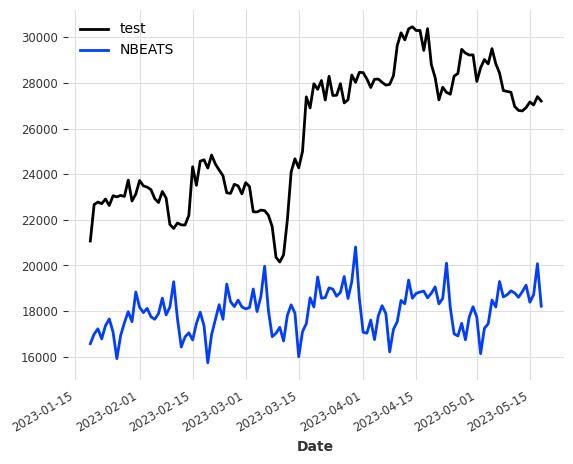

In [7]:
scaler = RobustScaler()

train_scaler = Scaler(scaler)
scaled_train = train_scaler.fit_transform(train)

nbeats = NBEATSModel(
    input_chunk_length=128,
    output_chunk_length=24,
    generic_architecture=True,
)

nbeats.fit(scaled_train, epochs=10)

scaled_pred_nbeats = nbeats.predict(n=120)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

mae_nbeats = mae(test, pred_nbeats)

print(mae_nbeats)
test.plot(label="test")
#pred_naive.plot(label="Baseline")
pred_nbeats.plot(label="NBEATS")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 9.0 M 
---------------------------------------------------
9.0 M     Trainable params
3.6 K     Non-trainable params
9.0 M     Total params
72.298    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

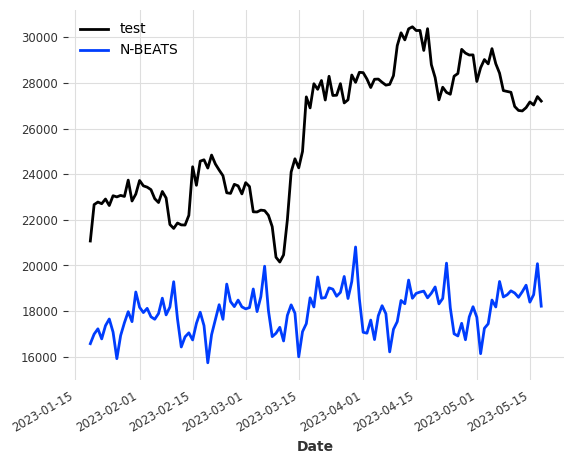

In [8]:
cov = concatenate(
    [
        dt_attr(series.time_index, "day", dtype=np.float32),
        dt_attr(series.time_index, "week", dtype=np.float32),
    ],
    axis="component",
)

cov_scaler = Scaler()
scaled_cov = cov_scaler.fit_transform(cov)

nbeats_cov = NBEATSModel(
    input_chunk_length=128,
    output_chunk_length=24,
    generic_architecture=True,
)

nbeats_cov.fit(scaled_train, past_covariates=scaled_cov, epochs=10)

scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=120)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

test.plot(label="test")
#pred_naive.plot(label="Baseline")
pred_nbeats.plot(label="N-BEATS")

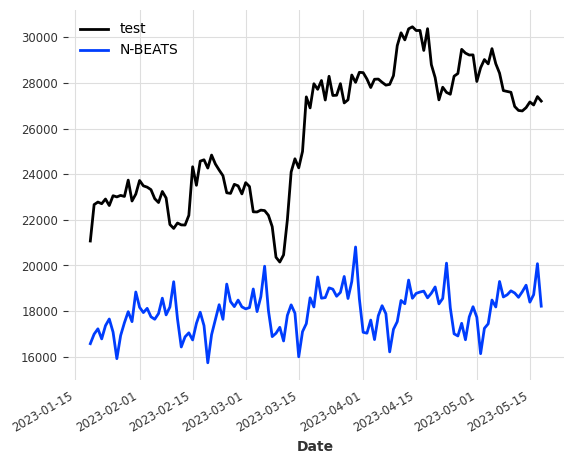

In [9]:
test.plot(label="test")

pred_nbeats.plot(label="N-BEATS")